These notebooks are used to compare a base and scenario, from surveys or model outputs, in H5 format. To run: from the menu bar above, choose **Cell -> Run All ** or run lines individually. Use the toggle button below to hide/show the raw Python code.

 ## School and Workplace Location Models

*Summaries for Daysim Models 1.1 - 1.5*

    - Workplace Location (1.1)
        - by County
        - by District
    - School Location (1.2)
        - by County
        - by District
    - Workers Paying to Park at Work (1.3)
        - by Workplace County
        - by Workplace District
    - Transit Pass Ownership (1.4)
       - by Workplace County 
       - by Workplace District
       - by Home County 
       - by Home District
    - Auto Ownership (1.5)
       - by County
       - by District
---

In [279]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [280]:
import os
import numpy as np
import pandas as pd
import h5py
import pylab as P
from IPython.display import display, display_pretty, Javascript, HTML
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
from matplotlib.backends.backend_pdf import PdfPages

# Show charts in notebook
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [281]:
# Load h5 or daysim outputs records
# Refering to 2 datasets as BASE and SCEN (scenario)

base = h5py.File(r'R:\SoundCast\estimation\2014\P5\skims_attached\survey14.h5','r+')
base_name = '2014 Survey'

# Note that expansion factor on daysim_outputs = 1 for each record, to allow direct comparison between survey records w/ exp. factor
scen = h5py.File(r'R:\SoundCast\releases\TransportationFutures2010\outputs\daysim_outputs.h5','r+')
scen_name = 'Daysim'

In [282]:
def build_df(h5file, h5table, var_dict, nested):
    ''' Convert H5 into dataframe '''
    data = {}
    if nested:
        # survey h5 have nested data structure, different than daysim_outputs
        for col_name, var in var_dict.iteritems():
            data[col_name] = [i[0] for i in h5file[h5table][var][:]]
    else:
        for col_name, var in var_dict.iteritems():
            data[col_name] = [i for i in h5file[h5table][var][:]]

    return pd.DataFrame(data)

In [283]:
# Columns to import from h5 for analysis
tripdict={'Household ID': 'hhno',
            'Person Number': 'pno',
            'Travel Time':'travtime',
            'Travel Cost': 'travcost',
            'Travel Distance': 'travdist',
            'Mode': 'mode',
            'Purpose (destination)':'dpurp',
            'Purpose (origin)':'opurp',
            'Departure Time': 'deptm',
            'Expansion Factor': 'trexpfac'}

In [284]:
trip_base = build_df(h5file=base, h5table='Trip', var_dict=tripdict, nested=False)
trip_scen = build_df(h5file=scen, h5table='Trip', var_dict=tripdict, nested=False)

In [285]:
# Columns to import from h5 for analysis
persondict={'Household ID': 'hhno',
            'Person Number': 'pno',
            'Transit Pass': 'ptpass',
            'Auto Time to Work': 'pwautime',
            'Auto Distance to Work': 'pwaudist',
            'Worker Type': 'pwtyp',
            'Student Type': 'pstyp',
            'Usual Commute Mode': 'puwmode',
            'Workplace TAZ': 'pwtaz',
            'School TAZ': 'pstaz',
            'Age': 'pagey',
            'Person Type': 'pptyp',
            'Expansion Factor': 'psexpfac'}

In [286]:
person_scen = build_df(h5file=scen, h5table='Person', var_dict=persondict, nested=False)
person_base = build_df(h5file=base, h5table='Person', var_dict=persondict, nested=False)

In [287]:
# Create unique ID for person by concatenating household ID and person number 
person_scen['personID'] = (person_scen['Household ID'].astype('str')+person_scen['Person Number'].astype('str')).astype('int')
person_base['personID'] = (person_base['Household ID'].astype('str')+person_base['Person Number'].astype('str')).astype('int')

In [288]:
hhdict={'Household ID': 'hhno',
        'Household Size': 'hhsize',
        'Household Vehicles': 'hhvehs',
        'Household Workers': 'hhwkrs',
        'Household Income': 'hhincome',
        'Household TAZ': 'hhtaz',
        'Expansion Factor': 'hhexpfac'}

In [289]:
hh_scen = build_df(h5file=scen, h5table='Household', var_dict=hhdict, nested=False)
hh_base = build_df(h5file=base, h5table='Household', var_dict=hhdict, nested=False)

In [290]:
# Add labels for worker type
labels = {
  0: "Not a worker",  
  1: "Full-time worker",
  2: "Part-time worker",
}

person_base['Worker Type'] = ([labels[x] for x in person_base['Worker Type']])
person_scen['Worker Type'] = ([labels[x] for x in person_scen['Worker Type']])

In [291]:
# Join household records to person records
hh_per_scen = pd.merge(left=person_scen, right=hh_scen,on='Household ID',suffixes=('_p','_h'))
hh_per_base = pd.merge(left=person_base, right=hh_base,on='Household ID',suffixes=('_p','_h'))

In [292]:
# Join household geography
taz_geog = pd.read_csv(r'utils/taz_lookup.csv')
taz_geog.reindex
hh_per_scen_home_geog = pd.merge(hh_per_scen, taz_geog, left_on='Household TAZ', right_on='TAZ')
hh_per_base_home_geog = pd.merge(hh_per_base, taz_geog, left_on='Household TAZ', right_on='TAZ')

In [293]:
# Join workplace geography
hh_per_scen_work_geog = pd.merge(hh_per_scen, taz_geog, left_on='Workplace TAZ', right_on='TAZ')
hh_per_base_work_geog = pd.merge(hh_per_base, taz_geog, left_on='Workplace TAZ', right_on='TAZ')

In [294]:
# Set some formatting options
pd.options.display.float_format = '{:.1f}%'.format    # set float format as percent, until further notice

In [295]:
def report_field(field, df_base, df_scen, title=None, figsize=(5,5)):
    '''print table summary of totals, distribution, and plot of distribution, for given field'''
    
    df = pd.DataFrame([df_base.groupby(field).sum()['Expansion Factor_h'].astype('int'),
                   df_scen.groupby(field).sum()['Expansion Factor_h'].astype('int')]).T
    df.columns=([scen_name,base_name])
    df.loc['Total'] = df.sum(axis=0)
    df['% Difference'] = ((df[scen_name] - df[base_name])/df[base_name])*100    # relative to base case
    
    print '--------Totals--------'
    print '' 
    print df
    
    print ''
    print ''
    print '-----Distribution-----'
    print ''

    
    df_new = pd.DataFrame([df[scen_name]/(df[scen_name].loc['Total']),
             df[base_name]/(df[base_name].loc['Total'])]).T*100
    df_new['% Difference'] = ((df_new[scen_name] - df_new[base_name])/df_new[base_name])*100    # relative to base case
    print df_new
    print ''
    df_new.drop(df_new.tail(1).index, inplace=True)    # do not plot totals columnn
    df_new[[scen_name,base_name]].plot(kind='bar', alpha=0.8, title=title, figsize=figsize)

---

## Workplace Location

### by County

--------Totals--------

            Daysim  2014 Survey  % Difference
King       1121029      1140109         -1.7%
Kitsap       79118       101795        -22.3%
Pierce      254531       285553        -10.9%
Snohomish   219565       258854        -15.2%
Total      1674243      1786311         -6.3%


-----Distribution-----

           Daysim  2014 Survey  % Difference
King        67.0%        63.8%          4.9%
Kitsap       4.7%         5.7%        -17.1%
Pierce      15.2%        16.0%         -4.9%
Snohomish   13.1%        14.5%         -9.5%
Total      100.0%       100.0%          0.0%



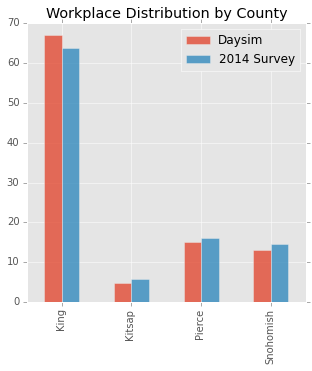

In [296]:
report_field(field='County', 
             df_base=hh_per_base_work_geog, 
             df_scen=hh_per_scen_work_geog, 
             title='Workplace Distribution by County')

### Workplace Location by District

--------Totals--------

                          Daysim  2014 Survey  % Difference
East Side                 341627       331061          3.2%
Everett-Lynwood-Edmonds   134170       152032        -11.7%
Kitsap                     79118       101795        -22.3%
North Seattle-Shoreline   145550       142736          2.0%
Renton-FedWay-Kent        236524       288721        -18.1%
S.Kitsap                   14534        19895        -26.9%
Seattle CBD               280301       247207         13.4%
South Pierce              122157       144052        -15.2%
Suburban Snohomish         85395       106822        -20.1%
Tacoma                    117838       121606         -3.1%
West-South Seattle        117025       130384        -10.2%
Total                    1674239      1786311         -6.3%


-----Distribution-----

                         Daysim  2014 Survey  % Difference
East Side                 20.4%        18.5%         10.1%
Everett-Lynwood-Edmonds    8.0%         8.5%        

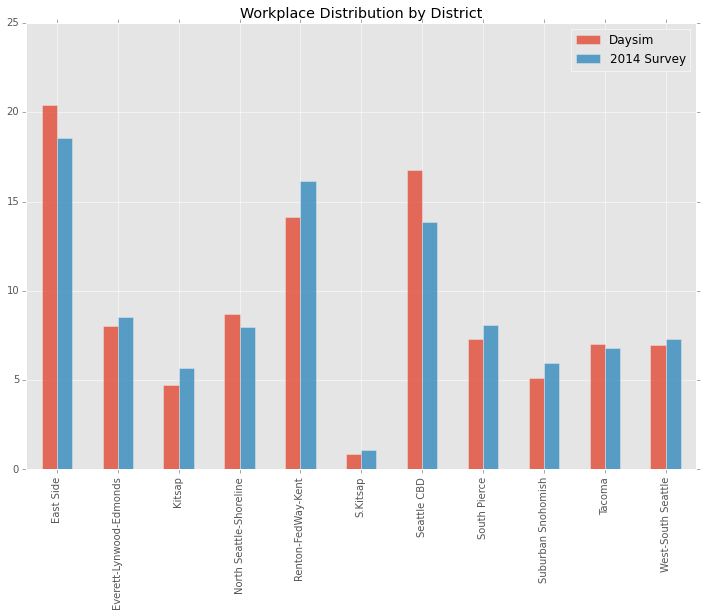

In [297]:
report_field('New DistrictName',
             df_base=hh_per_base_work_geog, 
             df_scen=hh_per_scen_work_geog, 
             title='Workplace Distribution by District', figsize=(12,8))

## Distance to Work

In [298]:
# Select all home -> work and work -> trips
def get_work_trips(df):
    
    # home to work trips
    work2home = df[df['Purpose (origin)'] == 1]    # select all work destination
    work2home = work2home[work2home['Purpose (destination)'] == 0]    # select all home origins

    # work to home trips
    home2work = df[df['Purpose (origin)'] == 0]    # select all work destination
    home2work = home2work[home2work['Purpose (destination)'] == 1]   # select all home origins

    # all work trips
    work_trips = work2home.append(home2work)
    
    return work_trips

In [299]:
def wt_mean(df, measure_col, weight_col, groupby_field=None):
    '''Compute weighted statistic for a dataframe'''
    
    if groupby_field:
        df['weighted'] = df[measure_col]*df[weight_col]
        result_df = df.groupby(groupby_field).sum()['weighted']/df.sum()[weight_col]
    else:
        result_df = (df[measure_col]*df[weight_col]).sum()/df[weight_col].sum()
    
    return result_df

In [300]:
pd.options.display.float_format = '{:.1f}'.format 

In [301]:
qork_trips_base = get_work_trips(trip_base)
work_trips_scen = get_work_trips(trip_scen)

In [302]:
# Exclude all -1 trips
work_trips_base = work_trips_base[work_trips_base['Travel Distance'] > 0]
work_trips_scen = work_trips_scen[work_trips_scen['Travel Distance'] > 0]

** Average Distance to Work/Home**

In [303]:
print base_name + ": " + str(wt_mean(df=work_trips_base, 
                                     measure_col='Travel Distance', 
                                     weight_col='Expansion Factor')/100)
print scen_name + ": " + str(wt_mean(df=work_trips_scen, 
                                     measure_col='Travel Distance', 
                                     weight_col='Expansion Factor'))

2014 Survey: 11.7616553021
Daysim: 13.489142888


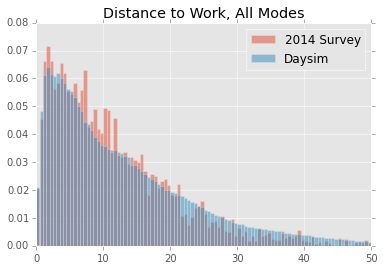

In [304]:
(work_trips_base['Travel Distance']/100).hist(bins=100, normed=True,
                                              weights=work_trips_base['Expansion Factor'].values,
                                             alpha=0.5, range=[0,50],
                                             label=base_name)

work_trips_scen['Travel Distance'].hist(bins=100, normed=True, 
                                        alpha=0.5, range=[0,50],
                                       label=scen_name)

pyplot.legend(loc='upper right')
pyplot.title('Distance to Work, All Modes')

---

## School Location

In [305]:
# Join school geography
hh_per_scen_school_geog = pd.merge(hh_per_scen, taz_geog, left_on='School TAZ', right_on='TAZ')
hh_per_base_school_geog = pd.merge(hh_per_base, taz_geog, left_on='School TAZ', right_on='TAZ')

### By County

--------Totals--------

            Daysim  2014 Survey  % Difference
King        692792       509961          35.9
Kitsap       63814        64244          -0.7
Pierce      239216       208352          14.8
Snohomish   187979       189855          -1.0
Total      1183801       972412          21.7


-----Distribution-----

           Daysim  2014 Survey  % Difference
King         58.5         52.4          11.6
Kitsap        5.4          6.6         -18.4
Pierce       20.2         21.4          -5.7
Snohomish    15.9         19.5         -18.7
Total       100.0        100.0           0.0



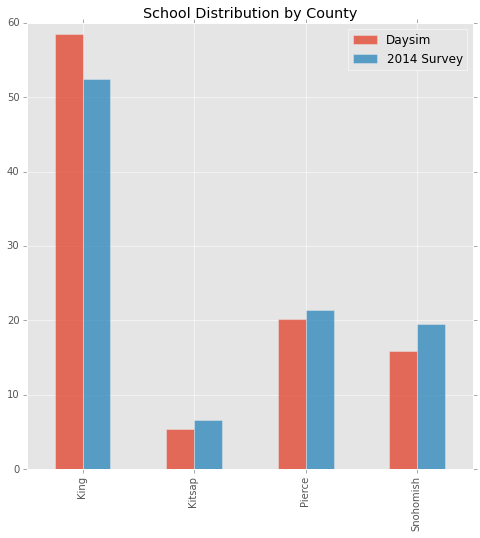

In [306]:
report_field(field='County',
             df_base=hh_per_base_school_geog, 
             df_scen=hh_per_scen_school_geog, 
             title='School Distribution by County', figsize=(8,8))

### School Location by District

--------Totals--------

                          Daysim  2014 Survey  % Difference
East Side                 239550       165228          45.0
Everett-Lynwood-Edmonds    89072        74502          19.6
Kitsap                     63814        64244          -0.7
North Seattle-Shoreline   156919        78851          99.0
Renton-FedWay-Kent        135589       161415         -16.0
S.Kitsap                   14677        13659           7.5
Seattle CBD               102559        49515         107.1
South Pierce              149147       128679          15.9
Suburban Snohomish         98907       115353         -14.3
Tacoma                     75392        66014          14.2
West-South Seattle         58174        54952           5.9
Total                    1183800       972412          21.7


-----Distribution-----

                         Daysim  2014 Survey  % Difference
East Side                  20.2         17.0          19.1
Everett-Lynwood-Edmonds     7.5          7.7        

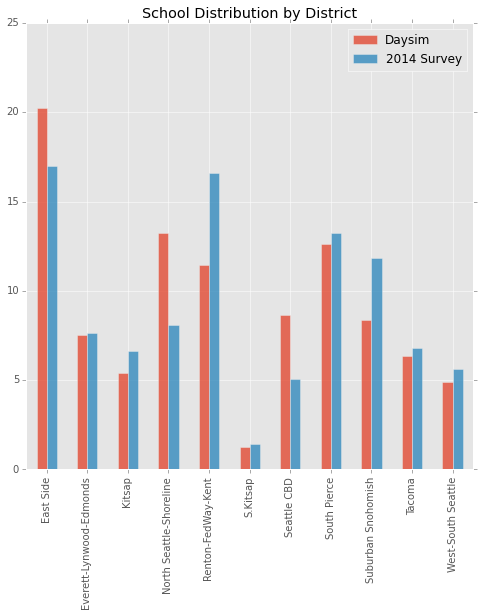

In [307]:
report_field(field='New DistrictName',
             df_base=hh_per_base_school_geog, 
             df_scen=hh_per_scen_school_geog, 
             title='School Distribution by District', figsize=(8,8))

# Transit Pass Ownership

In [308]:
# 2014 survey has multiple fields for transit pass ownership. Sum all non-zero fields into 1, for yes/no

# Drop -1 (no answer rows for transit pass)
df_pass_base_home = hh_per_base_home_geog[hh_per_base_home_geog['Transit Pass'] >= 0]
df_pass_base_work = hh_per_base_work_geog[hh_per_base_work_geog['Transit Pass'] >= 0]

# Convert categorical responses (different pass types) to binary yes/no
df_pass_base_home['Transit Pass'] = df_pass_base_home['Transit Pass'].apply(lambda x: 1 if x >=1 else 0)
df_pass_base_work['Transit Pass'] = df_pass_base_work['Transit Pass'].apply(lambda x: 1 if x >=1 else 0)

C:\Users\Brice\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Brice\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Region Wide

--------Totals--------

        Daysim  2014 Survey  % Difference
0      2299667      3088967         -25.6
1       467002       507572          -8.0
Total  2766669      3596539         -23.1


-----Distribution-----

       Daysim  2014 Survey  % Difference
0        83.1         85.9          -3.2
1        16.9         14.1          19.6
Total   100.0        100.0           0.0



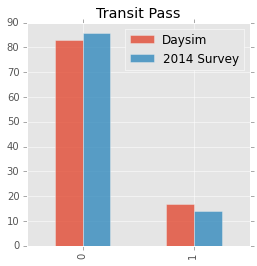

In [309]:
report_field('Transit Pass',
             df_base=df_pass_base_home, 
             df_scen=hh_per_scen_home_geog, 
             title='Transit Pass', figsize=(4,4))

## By Home County

In [310]:
def transit_pass(df_base, df_scen, geography, title=None):
    df_result = pd.DataFrame()

    # base
    df = pd.pivot_table(data=df_base, cols='Transit Pass', rows=geography, 
                   values='Expansion Factor_h', aggfunc='sum').astype('int')
    df_result[base_name] = (df[1]/df.sum(axis=1))*100
    df_result

    # scenario
    df = pd.pivot_table(data=df_scen, cols='Transit Pass', rows=geography, 
                   values='Expansion Factor_h', aggfunc='sum').astype('int')
    df_result[scen_name] = (df[1]/df.sum(axis=1))*100
    
    print df_result
    print ""
    print "--------------------------"
    print ""
    print df_result.plot(kind='bar', title=title, alpha=0.8)

           2014 Survey  Daysim
County                        
King              22.1    17.1
Kitsap            17.5     7.0
Pierce             8.4    10.8
Snohomish         11.0    12.2

--------------------------

Axes(0.125,0.125;0.775x0.775)


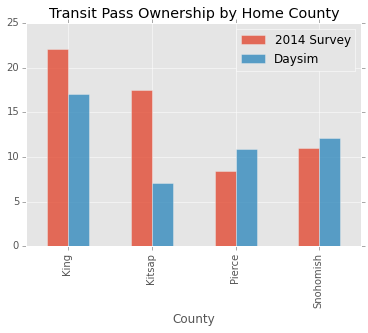

In [311]:
transit_pass(df_base=df_pass_base_home, 
             df_scen=hh_per_scen_home_geog, 
             geography='County', title='Transit Pass Ownership by Home County')

                         2014 Survey  Daysim
New DistrictName                            
East Side                       17.5    12.2
Everett-Lynwood-Edmonds         14.3    15.7
Kitsap                          17.5     7.0
North Seattle-Shoreline         31.3    23.9
Renton-FedWay-Kent              10.1    12.3
S.Kitsap                         5.9     5.8
Seattle CBD                     38.7    34.5
South Pierce                     6.0     9.5
Suburban Snohomish               8.9    10.0
Tacoma                          13.5    14.9
West-South Seattle              32.4    19.5

--------------------------

Axes(0.125,0.125;0.775x0.775)


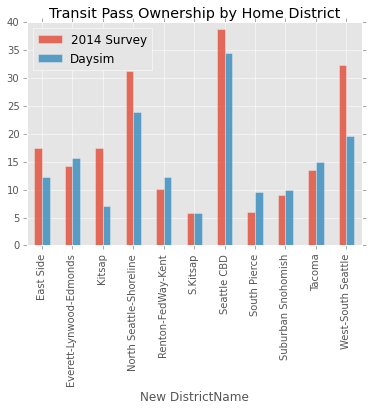

In [312]:
transit_pass(df_base=df_pass_base_home, 
             df_scen=hh_per_scen_home_geog, 
             geography='New DistrictName', title='Transit Pass Ownership by Home District')

### By Work Location

## County Work Location

           2014 Survey  Daysim
County                        
King              29.9    22.5
Kitsap            18.0     5.1
Pierce             6.6     8.8
Snohomish          8.4     8.3

--------------------------

Axes(0.125,0.125;0.775x0.775)


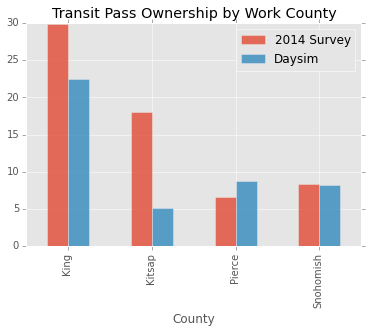

In [313]:
transit_pass(df_base=df_pass_base_work, 
             df_scen=hh_per_scen_work_geog, 
             geography='County', title='Transit Pass Ownership by Work County')

## by Work District

                         2014 Survey  Daysim
New DistrictName                            
East Side                       18.4    14.7
Everett-Lynwood-Edmonds         10.5    11.1
Kitsap                          18.0     5.1
North Seattle-Shoreline         33.2    23.7
Renton-FedWay-Kent              11.7    11.5
S.Kitsap                         4.4     5.3
Seattle CBD                     57.7    47.0
South Pierce                     2.5     5.3
Suburban Snohomish               5.2     4.1
Tacoma                          11.1    13.6
West-South Seattle              29.9    19.2

--------------------------

Axes(0.125,0.125;0.775x0.775)


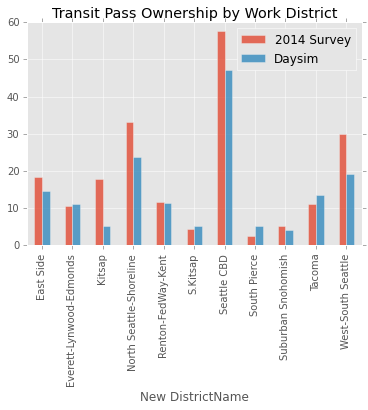

In [314]:
transit_pass(df_base=df_pass_base_work, 
             df_scen=hh_per_scen_work_geog, 
             geography='New DistrictName', title='Transit Pass Ownership by Work District')

---

# Auto Ownership

In [326]:
print 'Vehicles per Household'
df = pd.DataFrame([(hh_scen.groupby('Household Vehicles').sum()['Expansion Factor']),
                   hh_base.groupby('Household Vehicles').sum()['Expansion Factor']]).T
df.columns=([scen_name,base_name])
df.fillna(0,inplace=True)
df[scen_name] = df[scen_name].astype('int')
df[base_name] = df[base_name].astype('int')
df

Vehicles per Household


,Daysim,2014 Survey
Household Vehicles,,
0,110375,116720
1,421679,477848
2,562190,560222
3,240517,218361
4,114591,72856
5,0,22097
6,0,2295
7,0,4625
8,0,1874


In [327]:
print 'Distribution of Vehilces per Household'
df_new = pd.DataFrame([df[scen_name]/df[scen_name].sum(),
             df[base_name]/df[base_name].sum()]).T*100
df_new

Distribution of Vehilces per Household


,Daysim,2014 Survey
Household Vehicles,,
0,7.6,7.9
1,29.1,32.3
2,38.8,37.9
3,16.6,14.8
4,7.9,4.9
5,0.0,1.5
6,0.0,0.2
7,0.0,0.3
8,0.0,0.1


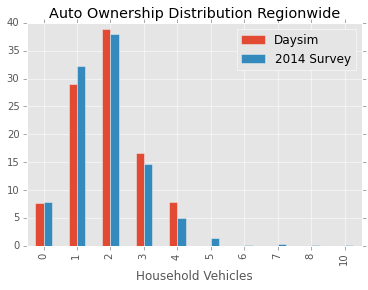

In [328]:
df_new.plot(kind='bar', title='Auto Ownership Distribution Regionwide')

In [319]:
# Average autos per household
print scen_name + ": " + str(sum(hh_scen['Household Vehicles']*hh_scen['Expansion Factor'])/sum(hh_scen['Expansion Factor']))
print base_name + ": " + str(sum(hh_base['Household Vehicles']*hh_base['Expansion Factor'])/sum(hh_base['Expansion Factor']))

Daysim: 1.8808226021
2014 Survey: 1.84776763947


In [320]:
# Auto Ownership by Income
# Create common income ranges
def map_income(df, in_field, out_field):
    
    # Define categories
    incmap = {}
    for i in range(0, 20000):
        incmap.update({i: ' <20k'})
    for i in range(20000, 40000):
        incmap.update({i: '20k-40k'})
    for i in range(40000, 60000):
        incmap.update({i: '40k-60k'})
    for i in range(60000, 75000):
        incmap.update({i: '60k-75k'})
    for i in range(75000, 100000):
        incmap.update({i: '75k-100k'})
    for i in range(100000, 150000):
        incmap.update({i: '100k-150k'})
    for i in range(150000, int(df[in_field].max())+1):
        incmap.update({i: '>150k'})

    df[out_field] = df[in_field].map(incmap)
    return df

In [321]:
hh_scen = map_income(hh_scen, in_field='Household Income', out_field='Income')
hh_base = map_income(hh_base, in_field='Household Income', out_field='Income')

In [322]:
df_scen = pd.pivot_table(data=hh_scen, index='Household Vehicles', columns=['Income'], 
                    aggfunc='sum', values='Expansion Factor', fill_value=False, margins=False)
df_base = pd.pivot_table(data=hh_base, index='Household Vehicles', columns=['Income'], 
                    aggfunc='sum', values='Expansion Factor', fill_value=False, margins=False)
# Sort the columns
df_scen = df_scen[[' <20k','20k-40k','40k-60k','60k-75k',
                   '75k-100k','100k-150k','>150k']]
df_base = df_base[[' <20k','20k-40k','40k-60k','60k-75k',
                   '75k-100k','100k-150k','>150k']]

In [323]:
df_scen.columns

Index([u' <20k', u'20k-40k', u'40k-60k', u'60k-75k', u'75k-100k', u'100k-150k', u'>150k'], dtype='object')

In [324]:
[sum(df_scen[colname]*df_scen.index)/sum(df_scen[colname]) for colname in df_scen.columns]

[0L, 1L, 1L, 2L, 2L, 2L, 2L]

In [325]:
# Calculate averages by income class
df = pd.DataFrame([[sum(df_scen[colname]*df_scen.index)/sum(df_scen[colname]) for colname in df_scen.columns],
                    [sum(df_base[colname]*df_base.index)/sum(df_base[colname]) for colname in df_base.columns]]).T
df.index=df_base.columns
df.columns=[scen_name,base_name]
df[scen_name] = df[scen_name].astype('int')
df[base_name] = df[base_name].astype('int')
df['% difference 2006->2014']= (df[base_name]-df[scen_name])/df[scen_name]
df

,Daysim,2014 Survey,% difference 2006->2014
Income,,,
<20k,0,1,inf
20k-40k,1,1,0.0
40k-60k,1,1,0.0
60k-75k,2,1,-0.5
75k-100k,2,2,0.0
100k-150k,2,2,0.0
>150k,2,2,0.0
